In [4]:
# !pip install -U onetick-ds-framework

In [1]:
import pandas as pd
from datetime import datetime
import dsframework
from dsframework.utils.func import build_experiment, build_experiment_class
from dsframework.impl.data_pipelines import CalcLags, TimeSplitter, FilterValues, LimitOutliers, ApplyLog, MinMaxScaler
from dsframework.impl.data_pipelines.ot_pipeline import ExpressionOperator, OIDSymbolOT, BaseOnetickLoader
from dsframework.impl.models import LGBMRegressor, XGBRegressor, CatBoostRegressor
from dsframework.impl.evaluators import MAEEvaluator, MAPEEvaluator, R2Evaluator, SMAPEEvaluator, RMSEEvaluator
from dsframework.impl.experiments import Experiment
import onetick.py as otp
otp.config['tz'] = 'EST5EDT'

'dsframework: ', dsframework.__version__, 'otp: ', otp.__version__

('dsframework: ', '1.0.7', 'otp: ', '1.57.5')

# Forecast trading volume in the next 10 minutes

In [2]:
trds = otp.DataSource('NYSE_TAQ_BARS', tick_type='TRD_1M')
trds = trds.agg({'VOLUME': otp.agg.sum('VOLUME')}, bucket_interval=600)
df = otp.run(trds, start=otp.dt(2023,4,12,9,31), end=otp.dt(2023,4,12,16,1), symbols='AAPL')

<Axes: xlabel='Time'>

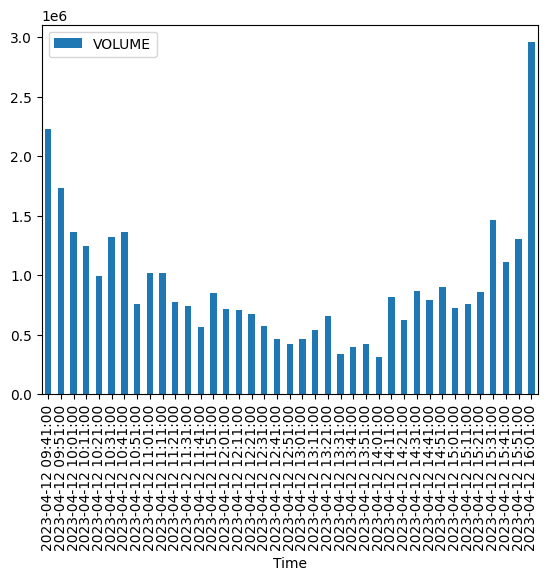

In [3]:
df.plot(x='Time', y='VOLUME', kind='bar')

# Define a query to fetch market data for creating features

In [4]:
class Bars(BaseOnetickLoader):
    
    def get_source(self):

        data = otp.DataSource(db=self.schema.db,
                              tick_type=self.schema.tick_type)
        
        data = data.agg(
            {
                'VOLUME': otp.agg.sum(data['VOLUME']),
                'VWAP_BUCKET_STD': otp.agg.stddev(data['VWAP'])
            },
            bucket_interval=self.bucket,
            bucket_time='start'
        )
        
        data = data.time_filter(start_time=self.start.strftime('%H%M%S%f')[:-3],
                                end_time=self.end.strftime('%H%M%S%f')[:-3],
                                timezone='EST5EDT')
        data, _ = data[data['VOLUME'] > 0]
        
        data = otp.functions.corp_actions(data,
                                          adjustment_date=int(self.end.strftime('%Y%m%d')),
                                          adjust_rule='SIZE',
                                          fields='VOLUME')
                                        
        return data

# Define an experiment

In [5]:
s = otp.dt(2022, 5, 10, 9, 31)
e = otp.dt(2022, 11, 10, 16, 1)
sym = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL']

class VolumePrediction(Experiment):    
    group_column_name = "SYMBOL_NAME"
    
    splitters = [TimeSplitter(val_time_range=(datetime(2022, 9, 10), datetime(2022, 10, 9)), 
                             test_time_range=(datetime(2022, 10, 10), datetime(2022, 11, 11)))]
    
    datafeeds = [Bars(db='NYSE_TAQ_BARS', tick_type='TRD_1M', symbols=sym, start=s, end=e, bucket=600)]
    
    pipeline = [
        CalcLags(periods=[1, 2, 3, 39, 40], columns=["VOLUME"], remove_first_rows=True),
        ExpressionOperator(
            new_column_name='HHMM',  
            expression=lambda tick: tick['Time'].dt.strftime('%H%M').apply(int)
        ),
        OIDSymbolOT(),
        ApplyLog(columns=['VOLUME','VOLUME_LAG_.*'])
    ]

    target_columns = ["VOLUME"]
    features_columns = ['VOLUME_LAG_.*', 'HHMM', 'OID'] 
    
    models = [
        LGBMRegressor(init_params={"num_leaves": [10, 20, 30], "max_depth": [3, 4, 5],},),
        XGBRegressor(init_params={"max_depth": [3, 4, 5]}),
    ]
    
    train_params = {
        "search_cv": {"val_type": "WalkForward", "folds": 5, "eval_metric": "MAE", "search_optimization": "grid",},
    }
    
    evaluators = [SMAPEEvaluator(), MAEEvaluator(), RMSEEvaluator(), R2Evaluator()]

# Run the experiment

In [6]:
exp = VolumePrediction()
metrics, predictions = exp.run()
metrics

{'VOLUME_SMAPE': 0.18942649258846136,
 'VOLUME_MAE': 226599.10190763825,
 'VOLUME_RMSE': 512473.3363485723,
 'VOLUME_R2': 0.7677468079133047}

In [8]:
metric_by_symbols_base = exp.calc_metrics(group_by_column=True)
pd.DataFrame(metric_by_symbols_base)

,AAPL,AMZN,GOOGL,MSFT,NVDA
VOLUME_SMAPE,0.172903,0.185068,0.213837,0.204189,0.171137
VOLUME_MAE,320259.272124,346244.239643,145283.335705,116596.805177,204611.856889
VOLUME_RMSE,593650.155199,825384.823945,320211.747161,272472.323229,320448.526333
VOLUME_R2,0.729136,0.669589,0.742859,0.667359,0.723826
